In [1]:
include("../code/exact_enum.jl")
include("../code/matrix_generator.jl")
include("../code/bp_full.jl")
include("../../telegram/notifications.jl")
using Base.Threads
nthreads()

22

In [2]:
ProgressMeter.ijulia_behavior(:clear);

In [3]:
n = 80
R = 1 // 4
m = round(Int, n*(1-R))
f3 = 1-3R
Λ = [0,1-f3,f3]
K = [0, 0, 1]
nedges = 3m 
rng = MersenneTwister(4)
H = permutedims(ldpc_matrix(n,m,nedges,Λ,K, rng=rng))
B, indep = findbasis_slow(H)
B = BitMatrix(B)
BB = augment_basis(B);

In [4]:
Blight, w = lightest_basis(BB, indep, n)

Finding lightest basis 5 	 Time: 0:00:01
  weight:  5

(Bool[1 0 … 0 1; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 17)

### Basis weight as n increases - RS regime

In [ ]:
R_rs = 1 // 4
ns_rs = 16 .* (1:7)
nsamples_rs = 100
weights_rs = [zeros(Int, nsamples_rs) for _ in ns_rs]
times_rs = zeros(length(ns_rs))
@telegram "Lightest basis RS" for (j,n) in enumerate(ns_rs)
    println("Size n=$n")
    t = @timed begin
        @threads for k in 1:nsamples_rs
            m = round(Int, n*(1-R_rs))
            f3 = 1-3R_rs
            nedges = 3m 
            Λ = [0,1-f3,f3]
            H = permutedims(ldpc_matrix(n,m,nedges,Λ,K, rng=MersenneTwister(k)))
            B, indep = findbasis_slow(H)
            B = BitMatrix(B)
            BB = augment_basis(B)
            Blight, weights_rs[j][k] = lightest_basis(BB, indep, n, showprogress=false)
        end
    end
    times_rs[j] = t.time
    flush(stdout)
end

Size n=16
Size n=32
Size n=48
Size n=64
Size n=80


In [ ]:
using DelimitedFiles
open("lightest_basis.txt", "w") do io
    writedlm(io, [ns_rs mean.(weights_rs) std.(weights_rs)./sqrt(nsamples_rs)])
end

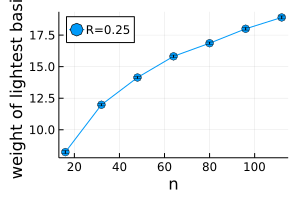

In [42]:
pl_rs = plot(ns_rs, mean.(weights_rs) , err=std.(weights_rs)./sqrt(nsamples_rs), label="R=$(float(R_rs))", m=:o,
    xlabel="n", ylabel="weight of lightest basis", legend=:topleft, size=(300,200))

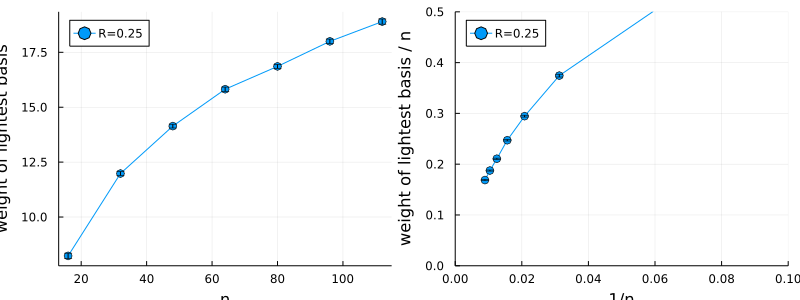

In [43]:
pl_rs2 = plot(1 ./ns_rs, mean.(weights_rs) ./ ns_rs, label="R=$(float(R_rs))", m=:o, 
    yerr=std.(weights_rs)./sqrt(nsamples_rs)./ ns_rs,
    xlabel="1/n", ylabel="weight of lightest basis / n", legend=:topleft, xlims=(0, 0.1), 
    ylims=(0,0.5))
plot(pl_rs, pl_rs2, size=(800,300))

### Basis weight as n increases - RSB regime

In [ ]:
R_rsb = 3 // 16
ns_rsb = 16 .* (1:9)
nsamples_rsb = 100
weights_rsb = [zeros(Int, nsamples_rsb) for _ in ns_rsb]
times_rsb = zeros(length(ns_rsb))
@telegram "Lightest basis RS" for (j,n) in enumerate(ns_rsb)
    println("Size n=$n")
    t = @timed begin
        @threads for k in 1:nsamples_rsb
            m = round(Int, n*(1-R_rsb))
            f3 = 1-3R_rsb
            nedges = 3m 
            Λ = [0,1-f3,f3]
            H = permutedims(ldpc_matrix(n,m,nedges,Λ,K, rng=MersenneTwister(k)))
            B, indep = findbasis_slow(H)
            B = BitMatrix(B)
            BB = augment_basis(B)
            Blight, weights_rsb[j][k] = lightest_basis(BB, indep, n, showprogress=false)
        end
        flush(stdout)
    end
    times_rsb[j] = t.time
end

Size n=16
Size n=32
Size n=48
Size n=64
Size n=80
Size n=96
Size n=112
Size n=128


In [ ]:
@telegram "Lightest basis RSB" sleep(1)

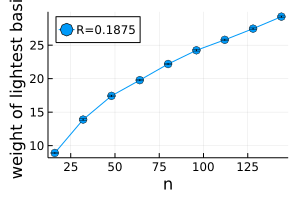

In [57]:
pl_rsb = plot(ns_rsb, mean.(weights_rsb) , err=std.(weights_rsb)./sqrt(nsamples_rsb), label="R=$(float(R_rsb))", m=:o,
    xlabel="n", ylabel="weight of lightest basis", legend=:topleft, size=(300,200))

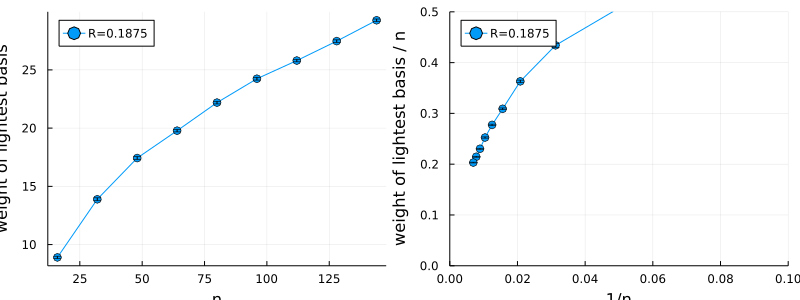

In [58]:
pl_rsb2 = plot(1 ./ns_rsb, mean.(weights_rsb) ./ ns_rsb , label="R=$(float(R_rsb))", m=:o,
    xlabel="1/n", ylabel="weight of lightest basis / n", legend=:topleft, xlims=(0, 0.1), 
    ylims=(0,0.5), err=std.(weights_rsb)./sqrt(nsamples_rsb) ./ ns_rsb)
 plot(pl_rsb, pl_rsb2, size=(800,300))

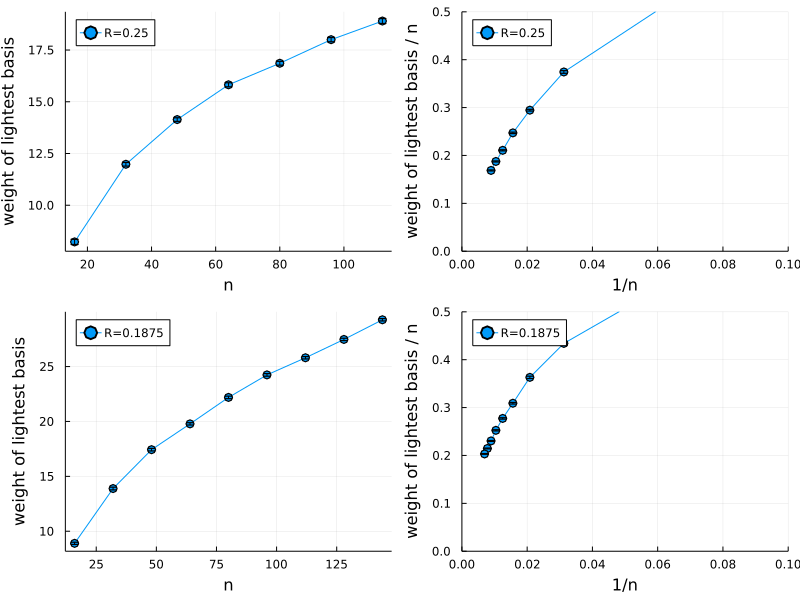

In [59]:
plot(pl_rs, pl_rs2, pl_rsb, pl_rsb2, size=(800,600))

In [ ]:
savefig("light_basis.png")

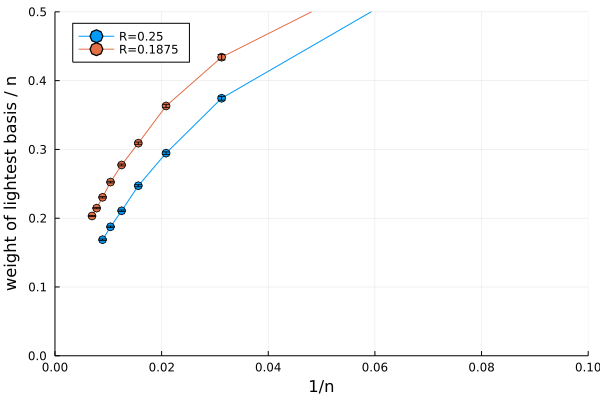

In [60]:
plot!(deepcopy(pl_rs2), 1 ./ns_rsb, mean.(weights_rsb) ./ ns_rsb , label="R=$(float(R_rsb))", m=:o,
    xlabel="1/n", ylabel="weight of lightest basis / n", legend=:topleft, xlims=(0, 0.1),
    err=std.(weights_rsb)./sqrt(nsamples_rsb) ./ ns_rsb)

In [274]:
savefig("light_basis2.png")

### Linear interpolation

In [18]:
include("../../.julia/dev/JuliaUtils/src/JuliaUtils.jl")
using .JuliaUtils

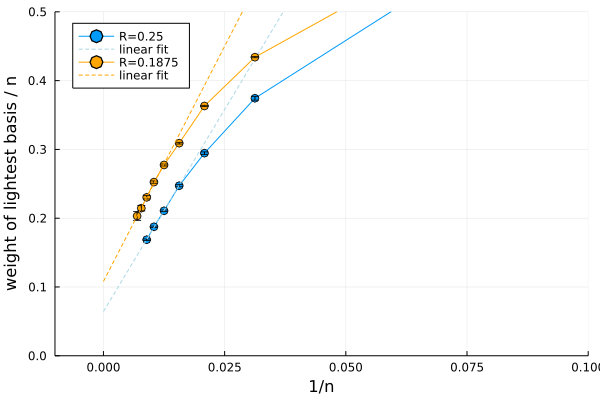

In [61]:
q = 3
x = reverse(1 ./ ns_rs)
y = reverse(mean.(weights_rs) ./ ns_rs)
stderr = reverse( std.(weights_rs)./sqrt(nsamples_rs) ./ ns_rs )
ls = linearls(x[1:q], y[1:q]; weights=1 ./ stderr[1:q])
xrange = 0:1e-3:0.1
yhat = predict(ls, xrange)
pl3 = deepcopy(pl_rs2)
plot!(pl3, xrange, yhat, label="linear fit", ls=:dash, c=:lightblue)
x = reverse(1 ./ ns_rsb)
y = reverse(mean.(weights_rsb) ./ ns_rsb)
stderr = reverse( std.(weights_rsb)./sqrt(nsamples_rsb) ./ ns_rsb )
ls = linearls(x[1:q], y[1:q]; weights=1 ./ stderr[1:q])
xrange = 0:1e-3:0.1
yhat = predict(ls, xrange)
plot!(pl3, 1 ./ns_rsb, mean.(weights_rsb) ./ ns_rsb , err=stderr, label="R=$(float(R_rsb))", m=:o, c=:orange)
plot!(pl3, xrange, yhat, label="linear fit", ls=:dash, c=:orange)
plot(pl3, xlims=(-0.01,0.1))

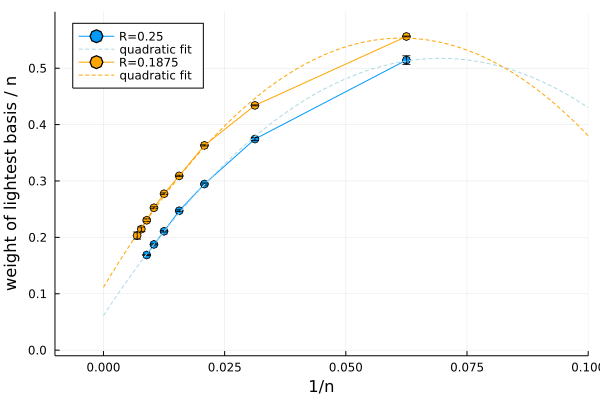

In [83]:
using GLM, DataFrames
q = 3
x = reverse(1 ./ ns_rs)
y = reverse(mean.(weights_rs) ./ ns_rs)
stderr = reverse( std.(weights_rs)./sqrt(nsamples_rs) ./ ns_rs )
# ls = linearls(x[1:q], y[1:q], x->x^2; weights=1 ./ stderr[1:q])
data = DataFrame(X=x, Y=y)
ls = lm(@formula(Y ~ X^2 + X), data, wts=1 ./ stderr)
xrange = 0:1e-3:0.1
yhat = GLM.predict(ls, DataFrame(X=xrange))
pl3 = deepcopy(pl_rs2)
plot!(pl3, xrange, yhat, label="quadratic fit", ls=:dash, c=:lightblue)
x = reverse(1 ./ ns_rsb)
y = reverse(mean.(weights_rsb) ./ ns_rsb)
stderr = reverse( std.(weights_rsb)./sqrt(nsamples_rsb) ./ ns_rsb )
# ls = linearls(x[1:q], y[1:q], x->x^2; weights=1 ./ stderr[1:q])
xrange = 0:1e-3:0.1
data = DataFrame(X=x, Y=y)
ls = lm(@formula(Y ~ X^2 + X), data, wts=1 ./ stderr)
xrange = 0:1e-3:0.1
yhat = GLM.predict(ls, DataFrame(X=xrange))
plot!(pl3, 1 ./ns_rsb, mean.(weights_rsb) ./ ns_rsb , err=stderr, label="R=$(float(R_rsb))", m=:o, c=:orange)
plot!(pl3, xrange, yhat, label="quadratic fit", ls=:dash, c=:orange)
plot(pl3, xlims=(-0.01,0.1), ylims=(-0.01, 0.6))